In [139]:
import pandas as pd
import numpy as np
import math
import statistics
import matplotlib.pyplot as plt
import zipfile
from datetime import datetime
from scipy import stats
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use('ggplot')

In [140]:
data = pd.read_csv('TXF1-分鐘-成交價.txt')
data.head()

,Date,Time,Open,High,Low,Close,TotalVolume
0,2000/1/4,09:01:00,8688.0,8688.0,8676.0,8680.0,67
1,2000/1/4,09:02:00,8662.0,8698.0,8662.0,8698.0,52
2,2000/1/4,09:03:00,8698.0,8700.0,8690.0,8700.0,31
3,2000/1/4,09:04:00,8700.0,8700.0,8680.0,8700.0,38
4,2000/1/4,09:05:00,8700.0,8700.0,8652.0,8680.0,44


In [141]:
data = data.rename(columns = dict(zip(data.columns, ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']))) #把欄位名稱重新命名
data.Date = pd.to_datetime(data.Date) #把原本欄位裡的Date、Time改成時間
data.Time = pd.to_timedelta(data.Time)
data = data.set_index(data.Date + data.Time).drop(columns = ['Date','Time']) #再把Date、Time併再一起放到index，再把原本的欄位丟掉

data['Year'] = data.index.map(lambda x: x.year)
data['Month'] = data.index.map(lambda x: x.month)
data['Weekday'] = data.index.map(lambda x: x.weekday)+1
data['Hour'] = data.index.map(lambda x: x.hour)
# 把時間欄位的細項抓出來

In [142]:
data.head()

,Open,High,Low,Close,Volume,Year,Month,Weekday,Hour
2000-01-04 09:01:00,8688.0,8688.0,8676.0,8680.0,67,2000,1,2,9
2000-01-04 09:02:00,8662.0,8698.0,8662.0,8698.0,52,2000,1,2,9
2000-01-04 09:03:00,8698.0,8700.0,8690.0,8700.0,31,2000,1,2,9
2000-01-04 09:04:00,8700.0,8700.0,8680.0,8700.0,38,2000,1,2,9
2000-01-04 09:05:00,8700.0,8700.0,8652.0,8680.0,44,2000,1,2,9


Text(0.5, 1.0, 'Volume History')

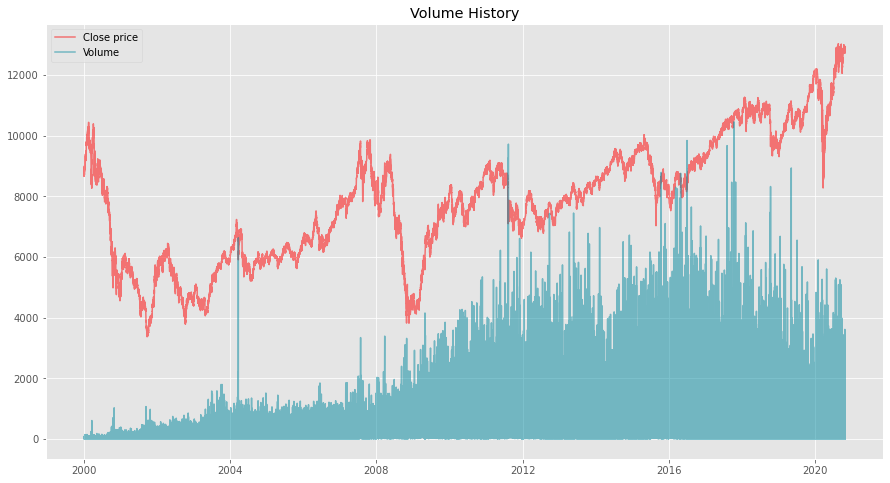

In [143]:
plt.figure(figsize = (15,8))
plt.plot(data.Close, color = 'red', alpha = 0.5, label = 'Close price') #把每分鐘的收盤價畫出來
plt.plot(data.Volume, color = '#01889f', alpha = 0.5, label = 'Volume') #成交量
plt.legend(loc = 'upper left')
plt.title('Volume History')

In [144]:
test_data = data[(data.index >= '2017-05-01 00:00:00')].copy()  #切在夜盤時間點之後
Morning = data[(data.Hour >= 8) & (data.Hour <= 13)] #切分日盤、夜盤
Night = data[(data.Hour < 8) | (data.Hour > 14)]

# # Part II. 外資期貨未平倉簡易波段策略

In [145]:
FOI = pd.read_csv('Foreign_OI.txt')
FOI.head()

,Unnamed: 0,Date,Foreign_OI
0,0,2010/1/4,2645.0
1,1,2010/1/5,2356.0
2,2,2010/1/6,3990.0
3,3,2010/1/7,-3326.0
4,4,2010/1/8,-4730.0


In [146]:
FOI.index = pd.to_datetime(FOI.Date) #轉成datetime格式並設成index
FOI = FOI.drop(columns = ['Unnamed: 0','Date']) #丟掉
FOI.head()

,Foreign_OI
Date,
2010-01-04,2645.0
2010-01-05,2356.0
2010-01-06,3990.0
2010-01-07,-3326.0
2010-01-08,-4730.0


In [147]:
#把分K轉成日K資料
#data.columns  ### ['Open', 'High', 'Low', 'Close', 'Volume', 'Year', 'Month', 'Weekday','Hour']
data = data.drop(columns = ['Year', 'Month', 'Weekday','Hour'])
data = data.resample('1d').agg(dict(zip(data.columns, ['first','max','min','last','sum'])))
data

,Open,High,Low,Close,Volume
2000-01-04,8688.0,8939.0,8650.0,8843.0,2800
2000-01-05,8718.0,8870.0,8671.0,8810.0,2854
2000-01-06,8840.0,9005.0,8820.0,8850.0,2501
2000-01-07,8781.0,8870.0,8711.0,8829.0,2409
2000-01-08,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...
2020-10-20,12888.0,12905.0,12813.0,12872.0,95118
2020-10-21,12873.0,12946.0,12758.0,12787.0,96558
2020-10-22,12787.0,12894.0,12707.0,12861.0,138829
2020-10-23,12860.0,12884.0,12795.0,12846.0,100541


In [148]:
df = pd.concat([data.Close, FOI.Foreign_OI], axis = 1, join = 'inner')
df.head()

,Close,Foreign_OI
2010-01-04,8166.0,2645.0
2010-01-05,8178.0,2356.0
2010-01-06,8320.0,3990.0
2010-01-07,8259.0,-3326.0
2010-01-08,8278.0,-4730.0


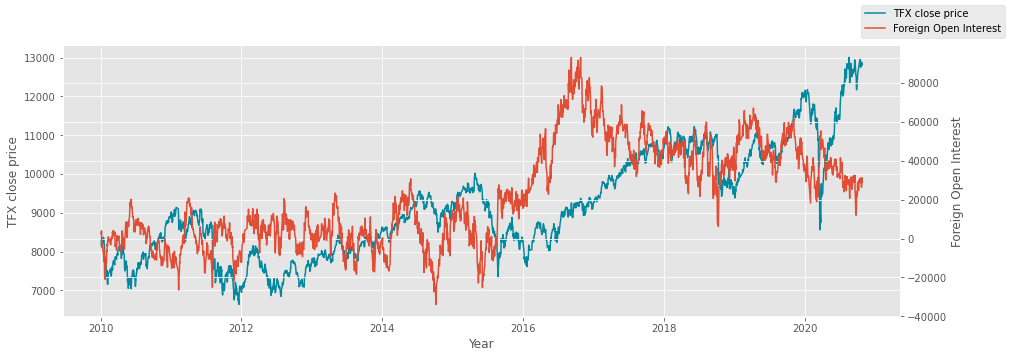

In [149]:
#把圖設兩個Y軸(一個在左邊、一個右邊)
fig, ax1 = plt.subplots(figsize = (15,5))
ax1.plot(df.Close.dropna(), color = '#01889f', alpha = 3, label = 'TFX close price')
ax2 = ax1.twinx() #把ax2的Y軸轉到右邊(具有共同 X 軸但不同 Y 軸的圖使用 twinx())
ax2.plot(df.Foreign_OI.dropna(), alpha = 5, label = 'Foreign Open Interest')
ax1.set_ylabel('TFX close price')
ax2.set_ylabel('Foreign Open Interest')
ax1.set_xlabel('Year')
fig.legend(loc = 'upper right') #legend把label顯示出來

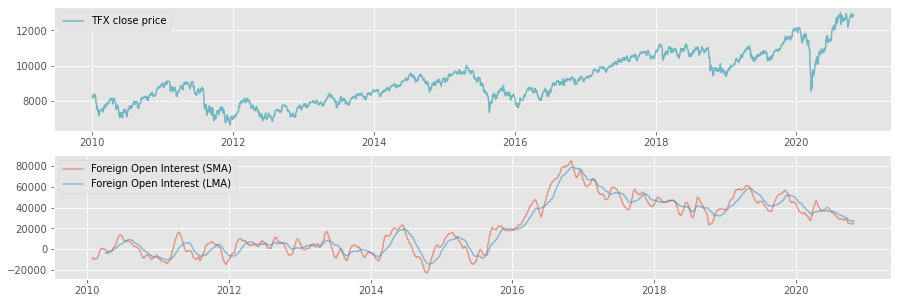

In [150]:
N1 = 20
N2 = 60
fig, (ax1, ax2) = plt.subplots(2, figsize = (15,5))
ax1.plot(df.Close.dropna(), color = '#01889f', alpha = 0.5, label = 'TFX close price')
ax1.legend()
ax2.plot(df.Foreign_OI.rolling(N1).mean().dropna(), alpha = 0.5, label = 'Foreign Open Interest (SMA)') #外資未平倉量的月線(20天)(短均線)
ax2.plot(df.Foreign_OI.rolling(N2).mean().dropna(), alpha = 0.5, label = 'Foreign Open Interest (LMA)') #外資未平倉量的季均線(長均線)
ax2.legend(loc = 'upper left')

In [151]:
df.Foreign_OI.rolling(N1).mean().dropna()

2010-01-29    -8086.00
2010-02-01    -8830.70
2010-02-02    -9255.05
2010-02-03    -9790.95
2010-02-04    -9852.95
                ...   
2020-10-19    24334.55
2020-10-20    24442.65
2020-10-21    24672.80
2020-10-22    25582.95
2020-10-23    26426.75
Name: Foreign_OI, Length: 2642, dtype: float64

## 回測

In [152]:
N1 = 20
N2 = 60
df['SMA'] = df.Foreign_OI.rolling(N1).mean().dropna() #把NA值拿掉(會沒辦法計算績效)
df['LMA'] = df.Foreign_OI.rolling(N2).mean().dropna()

signal = np.where((df.SMA >= df.LMA), 1, -1) #當短天期均線在長天期均線之上，把它定義成1(做多)，其餘時課定義成-1
signal_df = pd.Series(signal, index = df.index) #把df.index(日期) 和 signal組成dataframe
signal_df

2010-01-04   -1
2010-01-05   -1
2010-01-06   -1
2010-01-07   -1
2010-01-08   -1
             ..
2020-10-19   -1
2020-10-20   -1
2020-10-21   -1
2020-10-22   -1
2020-10-23   -1
Length: 2661, dtype: int32

## MACD策略 :  Foreign_OI 和 TXF
### 參考資料: https://smilehsu.cc/2020/06/2415

###  1. Foreign_OI 的MACD

In [153]:
#Calculate the MACD and Signal line indicators
#Calculate the short term exponential moving average (EMA)
#指數移動平均線
ShortEMA=df.Foreign_OI.ewm(span=12,adjust=False).mean() #指数加權滑動ewm() #快速線(12日EMA)、
#Calculate the long term exponential moving average (EMA)
LongEMA=df.Foreign_OI.ewm(span=26,adjust=False).mean() #慢速線(26日EMA)
#Calculat the MACD line
DIF=ShortEMA-LongEMA #差離值(DIF)
#Calculat the Signal line
MACD=MACD.ewm(span=9,adjust=False).mean() #9日DIF的EMA

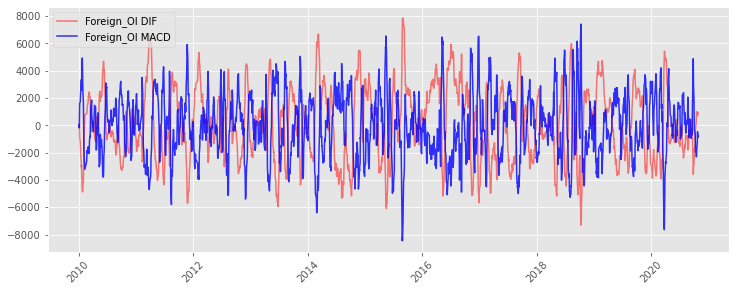

In [156]:
#畫圖
plt.figure(figsize=(12.2,4.5))
plt.xticks(rotation=45)
plt.plot(df.index , DIF, label='Foreign_OI DIF', color='red',alpha = 0.5 )
plt.plot(df.index , MACD, label='Foreign_OI MACD', color='Blue',alpha = 0.8)
plt.legend(loc='upper left')
plt.show()

In [157]:
df['DIF']=DIF
df['MACD']=MACD
df.head()

,Close,Foreign_OI,SMA,LMA,DIF,MACD
2010-01-04,8166.0,2645.0,NaN,NaN,0.000000,0.000000
2010-01-05,8178.0,2356.0,NaN,NaN,-23.054131,44.955556
2010-01-06,8320.0,3990.0,NaN,NaN,89.493819,-183.247901
2010-01-07,8259.0,-3326.0,NaN,NaN,-406.959996,820.947632
2010-01-08,8278.0,-4730.0,NaN,NaN,-903.281817,1627.693847


In [158]:
# create a funtion to signal when to buy and sell an asset
def Buy_Sell(signal2):
  Buy=[]
  Sell=[]
  flag=-1

  for i in range(0,len(signal2)):
    if signal2['DIF'][i] > signal2['MACD'][i]:  # DIF-MACD兩者相減，變成柱狀圖
      Sell.append(np.nan)
      if flag !=1:
        Buy.append(signal2['Close'][i])
        flag=1
      else:
        Buy.append(np.nan)
    elif signal2['DIF'][i] < signal2['MACD'][i]:
      Buy.append(np.nan)
      if flag !=0:
        Sell.append(signal2['Close'][i])
        flag=0
      else:
        Sell.append(np.nan)
    else:
      Buy.append(np.nan)
      Sell.append(np.nan)
 
  return(Buy,Sell)

In [159]:
a=Buy_Sell(df)
df['Buy_Signal_Price']=a[0]
df['Sell_Signal_Price']=a[1]

In [163]:
df.tail(15)

,Close,Foreign_OI,SMA,LMA,DIF,MACD,Buy_Signal_Price,Sell_Signal_Price
2020-09-30,12561.0,28959.0,25063.50,27756.800000,-1728.238131,-319.829068,NaN,NaN
2020-10-05,NaN,24809.0,24875.90,27595.650000,-1451.629049,-565.600301,NaN,NaN
2020-10-06,NaN,25011.0,24667.60,27357.983333,-1202.255791,-724.809055,NaN,NaN
2020-10-07,NaN,30080.0,24663.70,27292.666667,-588.812289,-1580.169655,NaN,NaN
2020-10-08,NaN,29468.0,24525.80,27257.033333,-150.304562,-1946.964266,NaN,NaN
2020-10-12,12951.0,29128.0,24536.05,27284.066667,167.845989,-2035.771390,NaN,NaN
2020-10-13,12921.0,31069.0,24477.95,27364.250000,570.034072,-2302.483760,NaN,NaN
2020-10-14,12868.0,30354.0,24528.60,27388.133333,821.605545,-2254.883291,NaN,NaN
2020-10-15,12798.0,29965.0,24546.60,27401.583333,978.311336,-2064.537074,NaN,NaN
2020-10-16,12749.0,28745.0,24522.50,27401.066667,992.615744,-1664.564448,NaN,NaN


In [164]:
df.head(5)

,Close,Foreign_OI,SMA,LMA,DIF,MACD,Buy_Signal_Price,Sell_Signal_Price
2010-01-04,8166.0,2645.0,NaN,NaN,0.000000,0.000000,NaN,NaN
2010-01-05,8178.0,2356.0,NaN,NaN,-23.054131,44.955556,NaN,8178.0
2010-01-06,8320.0,3990.0,NaN,NaN,89.493819,-183.247901,8320.0,NaN
2010-01-07,8259.0,-3326.0,NaN,NaN,-406.959996,820.947632,NaN,8259.0
2010-01-08,8278.0,-4730.0,NaN,NaN,-903.281817,1627.693847,NaN,NaN


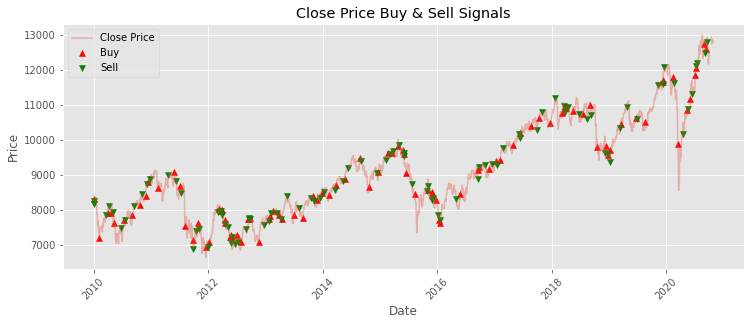

In [165]:
#Visually show the stock buy and sell signal
plt.figure(figsize=(12.2,4.5))
# ^ = shift + 6
plt.scatter(df.index,df['Buy_Signal_Price'],color='red', label='Buy',marker='^',alpha=1)
#小寫的v
plt.scatter(df.index,df['Sell_Signal_Price'],color='green', label='Sell',marker='v',alpha=1)
plt.plot(df['Close'], label='Close Price', alpha=0.35)
plt.title('Close Price Buy & Sell Signals')
#字斜45度角
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

In [166]:
ShortEMA=df.Close.ewm(span=12,adjust=False).mean() #指数加權滑動ewm()
LongEMA=df.Close.ewm(span=26,adjust=False).mean() 
DIF_TXF=ShortEMA-LongEMA
MACD_TXF=MACD.ewm(span=9,adjust=False).mean()

In [167]:
df['DIF_TXF']=DIF_TXF
df['MACD_TXF']=MACD_TXF
df.head()

,Close,Foreign_OI,SMA,LMA,DIF,MACD,Buy_Signal_Price,Sell_Signal_Price,DIF_TXF,MACD_TXF
2010-01-04,8166.0,2645.0,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.000000
2010-01-05,8178.0,2356.0,NaN,NaN,-23.054131,44.955556,NaN,8178.0,0.957265,8.991111
2010-01-06,8320.0,3990.0,NaN,NaN,89.493819,-183.247901,8320.0,NaN,13.023985,-29.456691
2010-01-07,8259.0,-3326.0,NaN,NaN,-406.959996,820.947632,NaN,8259.0,17.463450,140.624173
2010-01-08,8278.0,-4730.0,NaN,NaN,-903.281817,1627.693847,NaN,NaN,22.258319,438.038108


In [168]:
# create a funtion to signal when to buy and sell an asset
def Buy_Sell_TXF(signal2):
  Buy=[]
  Sell=[]
  flag=-1

  for i in range(0,len(signal2)):
    if signal2['DIF_TXF'][i] > signal2['MACD_TXF'][i]:
      Sell.append(np.nan)
      if flag !=1:
        Buy.append(signal2['Close'][i])
        flag=1
      else:
        Buy.append(np.nan)
    elif signal2['DIF_TXF'][i] < signal2['MACD_TXF'][i]:
      Buy.append(np.nan)
      if flag !=0:
        Sell.append(signal2['Close'][i])
        flag=0
      else:
        Sell.append(np.nan)
    else:
      Buy.append(np.nan)
      Sell.append(np.nan)
 
  return(Buy,Sell)

In [169]:
a=Buy_Sell_TXF(df)
df['Buy_Signal_Price_TXF']=a[0]
df['Sell_Signal_Price_TXF']=a[1]

In [172]:
df.tail(15)

,Close,Foreign_OI,SMA,LMA,DIF,MACD,Buy_Signal_Price,Sell_Signal_Price,DIF_TXF,MACD_TXF,Buy_Signal_Price_TXF,Sell_Signal_Price_TXF
2020-09-30,12561.0,28959.0,25063.50,27756.800000,-1728.238131,-319.829068,NaN,NaN,-52.749873,1742.518892,NaN,NaN
2020-10-05,NaN,24809.0,24875.90,27595.650000,-1451.629049,-565.600301,NaN,NaN,-52.749873,1280.895053,NaN,NaN
2020-10-06,NaN,25011.0,24667.60,27357.983333,-1202.255791,-724.809055,NaN,NaN,-52.749873,879.754232,NaN,NaN
2020-10-07,NaN,30080.0,24663.70,27292.666667,-588.812289,-1580.169655,NaN,NaN,-52.749873,387.769454,NaN,NaN
2020-10-08,NaN,29468.0,24525.80,27257.033333,-150.304562,-1946.964266,NaN,NaN,-52.749873,-79.177290,NaN,NaN
2020-10-12,12951.0,29128.0,24536.05,27284.066667,167.845989,-2035.771390,NaN,NaN,24.227899,-470.496110,NaN,NaN
2020-10-13,12921.0,31069.0,24477.95,27364.250000,570.034072,-2302.483760,NaN,NaN,45.873707,-836.893640,NaN,NaN
2020-10-14,12868.0,30354.0,24528.60,27388.133333,821.605545,-2254.883291,NaN,NaN,58.081976,-1120.491570,NaN,NaN
2020-10-15,12798.0,29965.0,24546.60,27401.583333,978.311336,-2064.537074,NaN,NaN,61.400911,-1309.300671,NaN,NaN
2020-10-16,12749.0,28745.0,24522.50,27401.066667,992.615744,-1664.564448,NaN,NaN,59.392658,-1380.353426,NaN,NaN


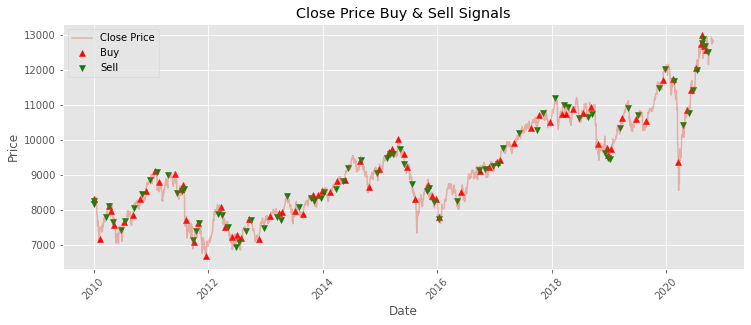

In [173]:
#Visually show the stock buy and sell signal
plt.figure(figsize=(12.2,4.5))
# ^ = shift + 6
plt.scatter(df.index,df['Buy_Signal_Price_TXF'],color='red', label='Buy',marker='^',alpha=1)
#小寫的v
plt.scatter(df.index,df['Sell_Signal_Price_TXF'],color='green', label='Sell',marker='v',alpha=1)
plt.plot(df['Close'], label='Close Price', alpha=0.35)
plt.title('Close Price Buy & Sell Signals')
#字斜45度角
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

## 回測

In [174]:
df.columns

Index(['Close', 'Foreign_OI', 'SMA', 'LMA', 'DIF', 'MACD', 'Buy_Signal_Price',
       'Sell_Signal_Price', 'DIF_TXF', 'MACD_TXF', 'Buy_Signal_Price_TXF',
       'Sell_Signal_Price_TXF'],
      dtype='object')

In [175]:
df.MACD

2010-01-04       0.000000
2010-01-05      44.955556
2010-01-06    -183.247901
2010-01-07     820.947632
2010-01-08    1627.693847
                 ...     
2020-10-19   -1345.445282
2020-10-20    -716.084678
2020-10-21    -460.967649
2020-10-22    -887.629603
2020-10-23    -730.369058
Name: MACD, Length: 2661, dtype: float64

In [107]:
#df.rename(columns={'Signal Line':'Signal_Line'}, inplace=True)
#df.Signal_Line

2010-01-04      0.000000
2010-01-05     -4.610826
2010-01-06     14.210103
2010-01-07    -70.023917
2010-01-08   -236.675497
                 ...    
2020-10-19    281.044471
2020-10-20    383.686503
2020-10-21    449.886723
2020-10-22    550.892663
2020-10-23    627.851980
Name: Signal_Line, Length: 2661, dtype: float64

In [177]:
#signal5 = np.arange(10)
#signal5 = np.where((df.MACD >= df.Signal Line), 1, -1) #當短天期均線在長天期均線之上，把它定義成1(做多)，其餘時課定義成-1
signal_df = pd.Series(np.where((df.DIF >= df.MACD), 1, -1), index = df.index) #把df.index(日期) 和 signal組成dataframe
signal_df

2010-01-04    1
2010-01-05   -1
2010-01-06    1
2010-01-07   -1
2010-01-08   -1
             ..
2020-10-19    1
2020-10-20    1
2020-10-21    1
2020-10-22    1
2020-10-23    1
Length: 2661, dtype: int32

In [229]:
signal_df.count(-1)

<ipython-input-229-1d787ebf2955>:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. ser.count(level=1) should use ser.groupby(level=1).count().
  signal_df.count(-1)


ValueError: Series.count level is only valid with a MultiIndex

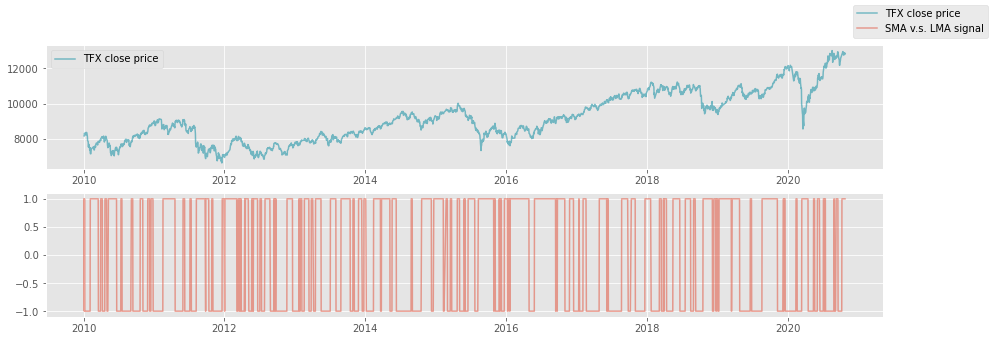

In [178]:
fig, (ax1, ax2) = plt.subplots(2, figsize = (15,5))
ax1.plot(df.Close.dropna(), color = '#01889f', alpha = 0.5, label = 'TFX close price') #第一個軸畫收盤價
ax2.plot(signal_df.dropna(), alpha = 0.5, label = 'SMA v.s. LMA signal') #第二個軸畫做多做空的策略訊號
fig.legend()
ax1.legend()

In [179]:
return_df = pd.concat([df.Close.pct_change(), signal_df.shift(2)], axis = 1).dropna() #Signal跟每天的收盤價併成一個dataframe
return_df

,Close,0
2010-01-06,0.017364,1.0
2010-01-07,-0.007332,-1.0
2010-01-08,0.002301,1.0
2010-01-11,0.005678,-1.0
2010-01-12,-0.002042,-1.0
...,...,...
2020-10-19,0.010903,1.0
2020-10-20,-0.001241,1.0
2020-10-21,-0.006603,1.0
2020-10-22,0.005787,1.0


In [180]:
return_df = pd.concat([df.Close.pct_change(), signal_df.shift(2)], axis = 1).dropna() #Signal跟每天的收盤價併成一個dataframe
# Close.pct_change() 是用close每天的變動率去算報酬 
#外資未平倉量在每天結束之後才會知道，所以你隔天收盤才進場，因此要shift(2)，所以報酬率跟後兩天的一樣

return_df.columns = ['d_return','position']
return_df['return'] = return_df.d_return * return_df.position #報酬率的計算方式
return_df

,d_return,position,return
2010-01-06,0.017364,1.0,0.017364
2010-01-07,-0.007332,-1.0,0.007332
2010-01-08,0.002301,1.0,0.002301
2010-01-11,0.005678,-1.0,-0.005678
2010-01-12,-0.002042,-1.0,0.002042
...,...,...,...
2020-10-19,0.010903,1.0,0.010903
2020-10-20,-0.001241,1.0,-0.001241
2020-10-21,-0.006603,1.0,-0.006603
2020-10-22,0.005787,1.0,0.005787


## 有安講評:
### 1.再加一個門檻(未平倉量>0)
### 2.記錄翻正當天指數的最高點，等突破再進場
### 3.其實pct_change()空單有誤差
### 4.可以加上回落的圖、多空單的比例


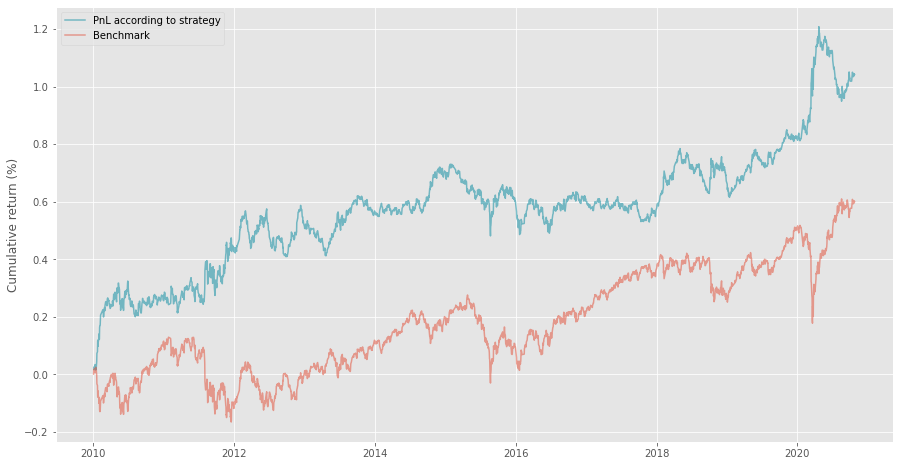

In [181]:
plt.figure(figsize = (15,8))
plt.plot(return_df['return'].dropna().cumsum(), alpha = 0.5, color = '#01889f', label = 'PnL according to strategy') #dropna()把NA拿掉；cumsum()獲利是累積的
plt.plot(df.Close.pct_change().dropna().cumsum(), alpha = 0.5, label = 'Benchmark') #單純一值持有台指期的績效(要贏過大盤)
plt.ylabel('Cumulative return (%)')
plt.legend()


In [182]:
#算出風暴比
MDD_series = return_df['return'].dropna().cumsum().cummax()-return_df['return'].dropna().cumsum() #之前累積下的最高點cumsum()- 減每天的變動率(知道今天距離上一次的高點有幾%)
MDD = max(MDD_series) #把最大值抓出來，就是最大虧損
Return_on_MDD = return_df['return'].dropna().cumsum()[-1] / MDD #把你賺的錢(cumsum()[-1]代表最後一個值)除以最大虧損
Return_on_MDD

4.02519195095692

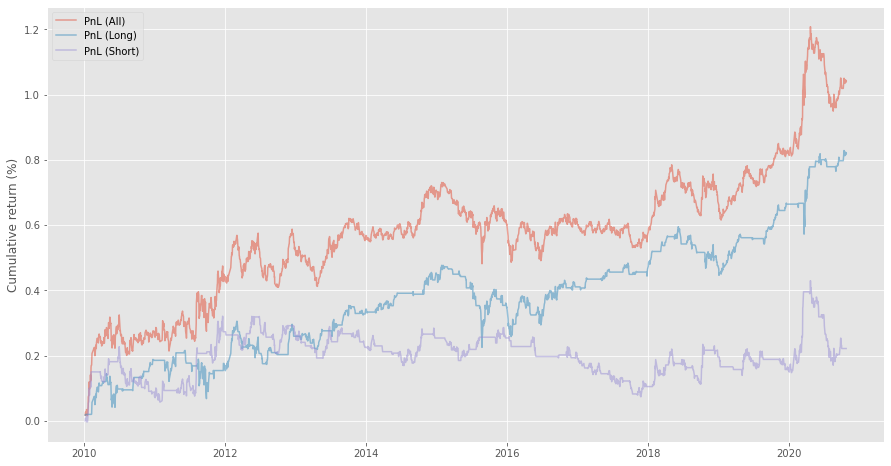

In [183]:
#把多空單拆開來做
signal_df_long = pd.Series(np.where(signal_df == 1, 1, 0), index = signal_df.index) #只保留1的部分
signal_df_short = pd.Series(np.where(signal_df == -1, -1, 0), index = signal_df.index) #只保留-1的部分(signal_df == -1, -1, 0):-1的部分保持-1，其它為0

return_df = pd.concat([df.Close.pct_change(), signal_df.shift(2), signal_df_long.shift(2), signal_df_short.shift(2)], axis = 1).dropna()
return_df.columns = ['d_return','position_all','position_long','position_short']
return_df['return_all'] = return_df.d_return * return_df.position_all
return_df['return_long'] = return_df.d_return * return_df.position_long
return_df['return_short'] = return_df.d_return * return_df.position_short
plt.figure(figsize = (15,8))
plt.plot(return_df['return_all'].dropna().cumsum(), alpha = 0.5, label = 'PnL (All)')
plt.plot(return_df['return_long'].dropna().cumsum(), alpha = 0.5, label = 'PnL (Long)')
plt.plot(return_df['return_short'].dropna().cumsum(), alpha = 0.5, label = 'PnL (Short)')
plt.ylabel('Cumulative return (%)')
plt.legend()

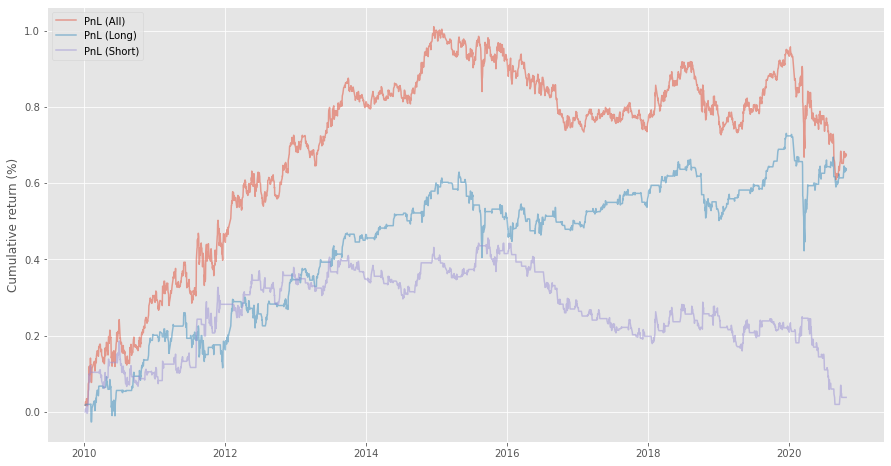

In [123]:

# 把多空單拆開來做
# signal_df_long = pd.Series(np.where(signal_df == 1, 1, 0), index = signal_df.index) #只保留1的部分
# signal_df_short = pd.Series(np.where(signal_df == -1, -1, 0), index = signal_df.index) #只保留-1的部分(signal_df == -1, -1, 0):-1的部分保持-1，其它為0

# return_df = pd.concat([df.Close.pct_change(), signal_df.shift(2), signal_df_long.shift(2), signal_df_short.shift(2)], axis = 1).dropna()
# return_df.columns = ['d_return','position_all','position_long','position_short']
# return_df['return_all'] = return_df.d_return * return_df.position_all
# return_df['return_long'] = return_df.d_return * return_df.position_long
# return_df['return_short'] = return_df.d_return * return_df.position_short
# plt.figure(figsize = (15,8))
# plt.plot(return_df['return_all'].dropna().cumsum(), alpha = 0.5, label = 'PnL (All)')
# plt.plot(return_df['return_long'].dropna().cumsum(), alpha = 0.5, label = 'PnL (Long)')
# plt.plot(return_df['return_short'].dropna().cumsum(), alpha = 0.5, label = 'PnL (Short)')
# plt.ylabel('Cumulative return (%)')
# plt.legend()

In [190]:
return_df

,d_return,position_all,position_long,position_short,return_all,return_long,return_short
2010-01-06,0.017364,1.0,1.0,0.0,0.017364,0.017364,0.000000
2010-01-07,-0.007332,-1.0,0.0,-1.0,0.007332,-0.000000,0.007332
2010-01-08,0.002301,1.0,1.0,0.0,0.002301,0.002301,0.000000
2010-01-11,0.005678,-1.0,0.0,-1.0,-0.005678,0.000000,-0.005678
2010-01-12,-0.002042,-1.0,0.0,-1.0,0.002042,-0.000000,0.002042
...,...,...,...,...,...,...,...
2020-10-19,0.010903,1.0,1.0,0.0,0.010903,0.010903,0.000000
2020-10-20,-0.001241,1.0,1.0,0.0,-0.001241,-0.001241,-0.000000
2020-10-21,-0.006603,1.0,1.0,0.0,-0.006603,-0.006603,-0.000000
2020-10-22,0.005787,1.0,1.0,0.0,0.005787,0.005787,0.000000


In [224]:
# Make the plot
x_sma = [] #短天期均線的參數
y_lma = [] #長天期均線的參數
z_RonMDD = [] #Z軸這邊用風暴比(也可以換sharp ratio等)

In [225]:
for i in range(2,20,1):  
    for j in range(6,35,2): #長天期的範圍
        
        N1 = i
        N2 = j
       
        ShortEMA=df.Foreign_OI.ewm(span= N1,adjust=False).mean() #指数加權滑動ewm()
        LongEMA=df.Foreign_OI.ewm(span=N2,adjust=False).mean() 
        df['DIF']=ShortEMA-LongEMA
        df['MACD']=(ShortEMA-LongEMA).ewm(span=9,adjust=False).mean()


        signal_df = pd.Series(np.where((df.DIF >= df.MACD), 1, -1), index = df.index) #把df.index(日期) 和 signal組成dataframe

        return_df = pd.concat([df.Close.pct_change(), signal_df.shift(2)], axis = 1).dropna()
        return_df.columns = ['d_return','position']
        return_df['return'] = return_df.d_return * return_df.position
        
        
        MDD_series = return_df['return'].dropna().cumsum().cummax()-return_df['return'].dropna().cumsum()
        MDD = max(MDD_series)
        Return_on_MDD = return_df['return'].dropna().cumsum()[-1] / MDD

        x_sma.append(i)
        y_lma.append(j)
        z_RonMDD.append(Return_on_MDD)
        #一個i、j的組合算一個風暴比塞回Z

In [227]:
%matplotlib qt 
fig = plt.figure(figsize = (10,5))
ax = fig.gca(projection='3d')  #用成3D的圖
ax.plot_trisurf(x_sma, y_lma, z_RonMDD, cmap=plt.cm.viridis, linewidth=0.2)
ax.set_xlabel('SMA')
ax.set_ylabel('LMA')
ax.set_zlabel('Return/MDD')
plt.show()

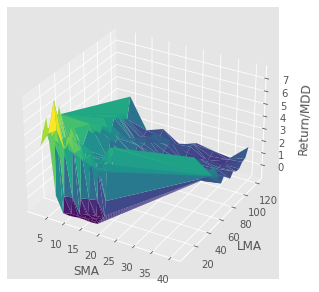

In [128]:
# fig = plt.figure(figsize = (10,5))
# ax = fig.gca(projection='3d')  #用成3D的圖
# ax.plot_trisurf(x_sma, y_lma, z_RonMDD, cmap=plt.cm.viridis, linewidth=0.2)
# ax.set_xlabel('SMA')
# ax.set_ylabel('LMA')
# ax.set_zlabel('Return/MDD')
# plt.show()

In [216]:
ShortEMA=df.Foreign_OI.ewm(span=2,adjust=False).mean() #指数加權滑動ewm()
LongEMA=df.Foreign_OI.ewm(span=7,adjust=False).mean() 
DIF=ShortEMA-LongEMA
MACD=MACD.ewm(span=9,adjust=False).mean()
df['DIF']=DIF
df['MACD']=MACD

signal_df = pd.Series(np.where((df.DIF >= df.MACD), 1, -1), index = df.index) #把df.index(日期) 和 signal組成dataframe

return_df = pd.concat([df.Close.pct_change(), signal_df.shift(2)], axis = 1).dropna() #Signal跟每天的收盤價併成一個dataframe

return_df.columns = ['d_return','position']
return_df['return'] = return_df.d_return * return_df.position #報酬率的計算方式
return_df


,d_return,position,return
2010-01-06,0.017364,1.0,0.017364
2010-01-07,-0.007332,-1.0,0.007332
2010-01-08,0.002301,1.0,0.002301
2010-01-11,0.005678,-1.0,-0.005678
2010-01-12,-0.002042,-1.0,0.002042
...,...,...,...
2020-10-19,0.010903,1.0,0.010903
2020-10-20,-0.001241,-1.0,0.001241
2020-10-21,-0.006603,-1.0,0.006603
2020-10-22,0.005787,-1.0,-0.005787


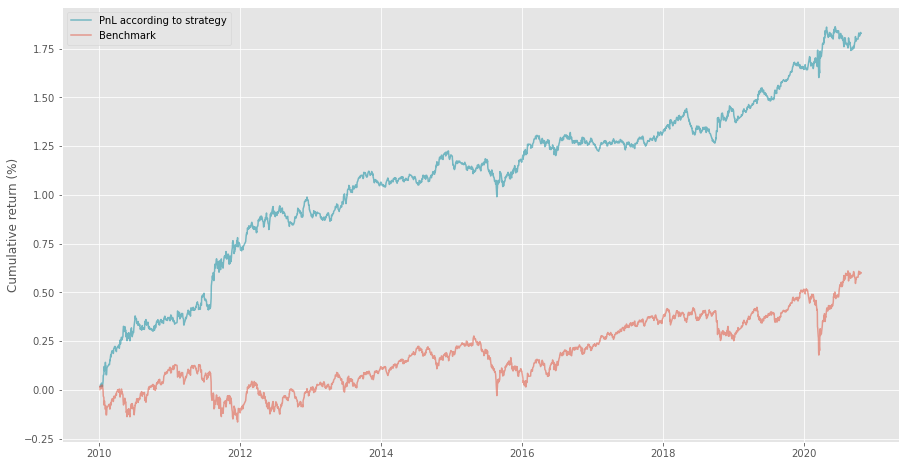

In [217]:
plt.figure(figsize = (15,8))
plt.plot(return_df['return'].dropna().cumsum(), alpha = 0.5, color = '#01889f', label = 'PnL according to strategy') #dropna()把NA拿掉；cumsum()獲利是累積的
plt.plot(df.Close.pct_change().dropna().cumsum(), alpha = 0.5, label = 'Benchmark') #單純一值持有台指期的績效(要贏過大盤)
plt.ylabel('Cumulative return (%)')
plt.legend()

### 2. TXF 的MACD

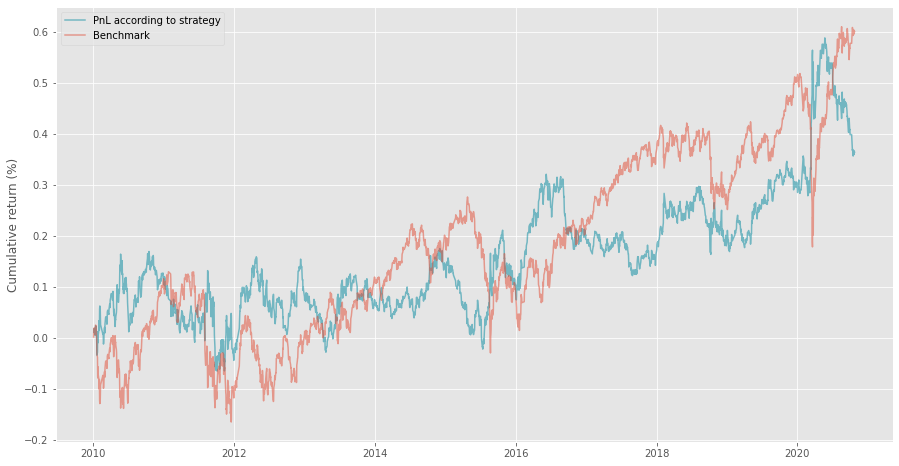

In [218]:
ShortEMA_TXF=df.Close.ewm(span= 12,adjust=False).mean() #指数加權滑動ewm()
LongEMA_TXF=df.Close.ewm(span=26,adjust=False).mean() 
DIF_TXF=ShortEMA_TXF-LongEMA_TXF
MACD_TXF=(ShortEMA_TXF-LongEMA_TXF).ewm(span=9,adjust=False).mean()
df['DIF_TXF']=DIF_TXF
df['MACD_TXF']=MACD_TXF

signal_df_TXF = pd.Series(np.where((df.DIF_TXF >= df.MACD_TXF), 1, -1), index = df.index) #把df.index(日期) 和 signal組成dataframe

return_df_TXF = pd.concat([df.Close.pct_change(), signal_df_TXF.shift(2)], axis = 1).dropna()
return_df_TXF.columns = ['d_return','position']
return_df_TXF['return'] = return_df_TXF.d_return * return_df_TXF.position


MDD_series_TXF = return_df_TXF['return'].dropna().cumsum().cummax()-return_df_TXF['return'].dropna().cumsum()
MDD_TXF = max(MDD_series_TXF)
Return_on_MDD_TXF = return_df_TXF['return'].dropna().cumsum()[-1] / MDD_TXF

plt.figure(figsize = (15,8))
plt.plot(return_df_TXF['return'].dropna().cumsum(), alpha = 0.5, color = '#01889f', label = 'PnL according to strategy') #dropna()把NA拿掉；cumsum()獲利是累積的
plt.plot(df.Close.pct_change().dropna().cumsum(), alpha = 0.5, label = 'Benchmark') #單純一值持有台指期的績效(要贏過大盤)
plt.ylabel('Cumulative return (%)')
plt.legend()

In [219]:
# Make the plot
x_sma_TXF = [] #短天期均線的參數
y_lma_TXF = [] #長天期均線的參數
z_RonMDD_TXF = [] #Z軸這邊用風暴比(也可以換sharp ratio等)

In [222]:
for i in range(2,20,1):  
    for j in range(6,35,2): #長天期的範圍
        
        N1_TXF = i
        N2_TXF = j
       
        ShortEMA_TXF=df.Foreign_OI.ewm(span= N1_TXF,adjust=False).mean() #指数加權滑動ewm()
        LongEMA_TXF=df.Foreign_OI.ewm(span=N2_TXF,adjust=False).mean() 
        
        DIF_TXF=ShortEMA_TXF-LongEMA_TXF
        MACD_TXF=(ShortEMA_TXF-LongEMA_TXF).ewm(span=9,adjust=False).mean()
        df['DIF_TXF']=DIF_TXF
        df['MACD_TXF']=MACD_TXF

        signal_df_TXF = pd.Series(np.where((df.DIF_TXF >= df.MACD_TXF), 1, -1), index = df.index) #把df.index(日期) 和 signal組成dataframe

        return_df_TXF = pd.concat([df.Close.pct_change(), signal_df_TXF.shift(2)], axis = 1).dropna()
        return_df_TXF.columns = ['d_return','position']
        return_df_TXF['return'] = return_df_TXF.d_return * return_df_TXF.position

        MDD_series_TXF = return_df_TXF['return'].dropna().cumsum().cummax()-return_df_TXF['return'].dropna().cumsum()
        MDD_TXF = max(MDD_series_TXF)
        Return_on_MDD_TXF = return_df_TXF['return'].dropna().cumsum()[-1] / MDD_TXF

        x_sma_TXF.append(i)
        y_lma_TXF.append(j)
        z_RonMDD_TXF.append(Return_on_MDD_TXF)
        #一個i、j的組合算一個風暴比塞回Z

In [228]:
%matplotlib qt 
fig = plt.figure(figsize = (10,5))
ax = fig.gca(projection='3d')  #用成3D的圖
ax.plot_trisurf(x_sma_TXF, y_lma_TXF, z_RonMDD_TXF, cmap=plt.cm.viridis, linewidth=0.2)
ax.set_xlabel('SMA')
ax.set_ylabel('LMA')
ax.set_zlabel('Return/MDD')
plt.show()